# FINM 33150 Homework 1: Futures Spread Dynamics

Sean Lin

Student ID: 12375235

***

## 1 Introduction

In this assignment, spreads from two different future pairs (4 future contracts total) were obtained and created based on the last two digits of my student ID. Certain dynamics of the spreads were analyzed and comparisons were made between the two pairs. The goal of the assignment is to predominantly serve as a data science assignment aimed at data collection and basic statistical analysis in order to be more comfortable with more complex quantitative finance topics later on in the quarter. 

In [154]:
import os
import pandas as pd
import numpy as np 
import quandl
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats

In [155]:
KEY = os.getenv('QUANDL_KEY') # If you want to run the notebook on your own, set this to your own API key 

## 2 Data

The second monthly quarter future prices were obtained from the Quandl OWF database for two pairs (W, X; Y, Z) based on the last two digits of my student ID number for Dec 03 2020 through Aug 31 2022. Here, the second month is defined as the contract where the number of days to future expiration is the smallest available value greater than 30. Spreads, $s_t^{(1)}$, $s_t^{(2)}$, were formed between the future price and defined as the difference $s_t^{(1)} = X_t - W_t$ and $s_t^{(2)} = Z_t - Y_t$

The last 2 digits of my student ID are 3 and 5, so the following spreads were created: 

3\. $\text{CBT\_FV\_FV}$ versus $\text{CBT\_TU\_TU} × 1.1066$

5\. $\text{CBT\_FV\_FV}$ versus $\text{CBT\_US\_US} × 0.7595$

***

**2.1 Processing Data** 

First, the function `get_contract` is created to easily obtain OWF future contract price data from any time-interval whilst simultaneously applying any multiplier ($\text{CBT\_TU\_TU}$ and $\text{CBT\_US\_US}$). Afterwards, the function is used to collect price data of $\text{CBT\_FV\_FV}$, $\text{CBT\_TU\_TU} × 1.1066$, and $\text{CBT\_US\_US} × 0.7595$. These are stored in the variables $\text{fv}, \text{tu}$, and $\text{us}$ respectively. The spreads are then created according to the following formulation: $s_t = X_t - W_t$ and are stored in the variables $\text{s1}$ and $\text{s2}$ to be used downstream in data analysis. $\text{s1}$ contains Spread 3 while $\text{s2}$ contains Spread 5. 

In [156]:
def get_contract(name,years,month_codes,start='2020-12-03',end='2022-08-31',multiplier=1): 
    '''
    Obtains future contract price information given the month and year codes 

    Parameters:
        name (string): Name of the contract assuming OWF database 
        years (list): List of years of contract expiry
        month_codes (list): List of month codes of contract expiry 
        start (string): The start date of price data (default 2020-21-03)
        end (string): The end date of price data (default 2022-08-31)
        multiplier (float): Multiplier that is applied to the future price (default 1)

    Returns:
        df_filtered (df): Dataframe consisting of future price time-series with desired multiplier applied 
    '''
    df = pd.DataFrame()
    for y in years:
        for m in month_codes:
            code = 'OWF/' + name + '_' + m + y + '_IVM'
            qdata = quandl.get(code, returns='pandas', api_key=KEY, start_date=start, end_date=end)
            df = pd.concat([df, qdata.reset_index()])
    df_filtered = df.sort_values(by=['Date','DtT'])
    df_filtered = df_filtered[df_filtered.DtT >= 30].groupby('Date').first()
    df_filtered = multiplier * df_filtered[['Future']].rename(columns={'Future':'Price'})
    return df_filtered

In [157]:
years = ['2021','2022']
month_codes = ['H','M','U','Z']

fv = get_contract('CBT_FV_FV', years, month_codes)
tu = get_contract('CBT_TU_TU', years, month_codes, multiplier=1.1066)
us = get_contract('CBT_US_US', years, month_codes, multiplier=0.7595)

In [158]:
s1 = (tu - fv).rename(columns={'Price':'Spread'}) # CBT_TU_TU - CBT_FV_FV spread (s1 from now on)
s2 = (us - fv).rename(columns={'Price':'Spread'}) # CBT_US_US - CBT_FV_FV spread (s2 from now on)

***

**2.2 Spread Validation**

The spreads were first verified using the examples provided in the homework document. This ensures that the proper results are used for data analysis. The validation results are displayed using a DataFrame.

$\text{CBT\_FV\_FV}$ versus $\text{CBT\_TU\_TU}$ Verification
- 2021-11-25 0.156306
- 2021-11-26 -0.181877

$\text{CBT\_FV\_FV}$ versus $\text{CBT\_US\_US}$ Verification
- 2021-11-19 1.271594
- 2021-11-24 -0.658906
- 2021-11-26 1.274656

In [10]:
fvtu_val = pd.DataFrame(index=['2021-11-25','2021-11-26'],columns=['Expected','Actual']) # obtaining certain spread values to validate with examples 
fvtu_val['Expected'] = [.156306, -.181877]
fvtu_val['Actual'] = s1.loc[fvtu_val.index] 

fvus_val = pd.DataFrame(index=['2021-11-19','2021-11-24','2021-11-26'],columns=['Expected','Actual'])
fvus_val['Expected'] = [1.271594, -0.658906, 1.274656]
fvus_val['Actual'] = s2.loc[fvus_val.index]

In [11]:
print('Spread 3 Validation')
fvtu_val 

Spread 3 Validation


,Expected,Actual
2021-11-25,0.156306,0.156306
2021-11-26,-0.181877,-0.181877


In [12]:
print('Spread 5 Validation')
fvus_val

Spread 5 Validation


,Expected,Actual
2021-11-19,1.271594,1.271594
2021-11-24,-0.658906,-0.658906
2021-11-26,1.274656,1.274656


The calculated spreads are equal to the example spreads from the homework PDF.

***

## 3 Analysis

The relative dynamics of $s_t^{(i)}$ are characterized using charts and statistics. First, analysis on the spreads is done by plotting and calculating correlation. Afterwards, the spreads are *normalized* in the sense that an N day moving average is calculated and then subtracted from the respective spreads. This is denoted as the difference. These differences are compared to each other via standard statistics (mean, median, etc), tail statistics, and correlation calculations. 

**3.1 Plotting Futures**

First, the futures (along with their multipliers) are plotted to gain a sense of the price. To make things more interpretable, the (multiplied) future prices are plotted with their pair.

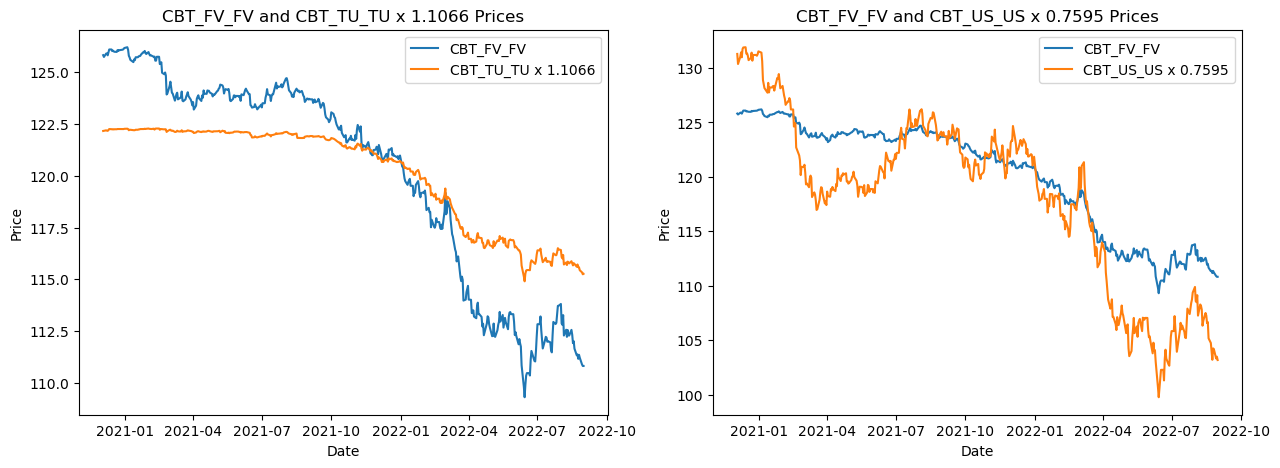

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5)) # plotting future prices 
ax1.plot(fv,label='CBT_FV_FV')
ax1.plot(tu,label='CBT_TU_TU x 1.1066')
ax1.title.set_text('CBT_FV_FV and CBT_TU_TU x 1.1066 Prices')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend()

ax2.plot(fv,label='CBT_FV_FV')
ax2.plot(us,label='CBT_US_US x 0.7595')
ax2.title.set_text('CBT_FV_FV and CBT_US_US x 0.7595 Prices')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price')
ax2.legend()


From looking at the graph, all three future contracts are in a downtrend. In the left plot, CBT_FV_FV has a steeper slope downwards while in the right plot, CBT_US_US x 0.7595 has a steeper slope. CBT_TU_TU has a relatively flat slope up until the end of 2021. CBT_US_US x 0.7595 also has a period where the price remaisn in a range. 

***

**3.2 Plotting Spreads**

The spreads (3 and 5) are plotted to examine the spread trend throughout the entire time-series. As a reminder, these are constructed as follows (the multipliers are not included for simplicity):

$s_1 = \text{CBT\_TU\_TU} - \text{CBT\_FV\_FV}$

$s_2 = \text{CBT\_US\_US} - \text{CBT\_FV\_FV}$

Text(0.5, 1.0, '0.7595 CBT_US_US - CBT_FV_FV')

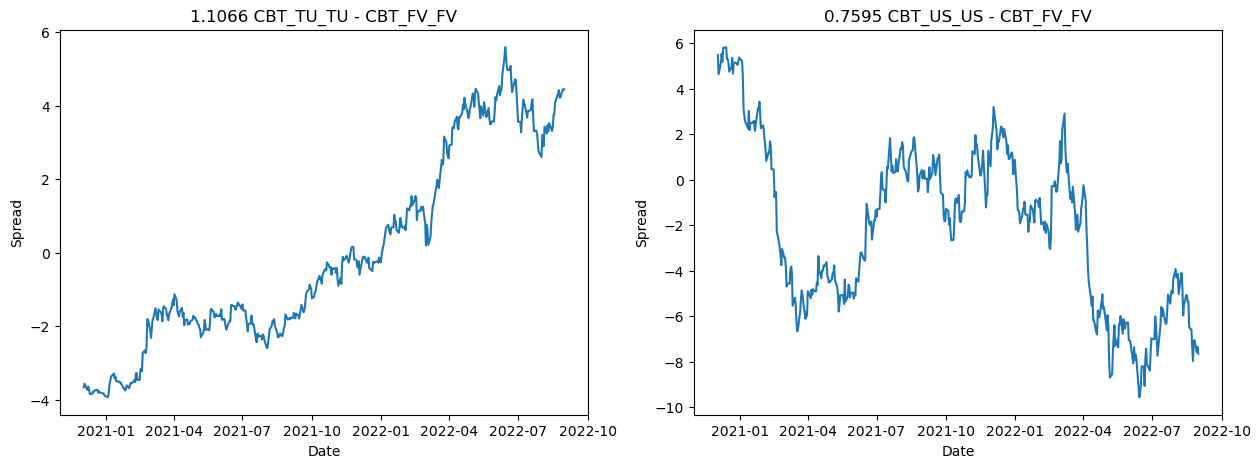

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5)) # plotting spreads on separate plots 
ax1.plot(s1)
ax2.plot(s2)

ax1.set_xlabel('Date')
ax1.set_ylabel('Spread')
ax1.set_title('1.1066 CBT_TU_TU - CBT_FV_FV')

ax2.set_xlabel('Date')
ax2.set_ylabel('Spread')
ax2.set_title('0.7595 CBT_US_US - CBT_FV_FV')

When examining the spreads, the left plot is in an uptrend while the right plot is in a downtrend. However, the right plot has a time interval (between 2021-07 and 2022-04) where the spreads are moving within a range and may be stationary. The CBT_TU_TU - CBT_FV_FV spread ($\text{s1}$) looks to have a larger drift and does not look stationary compared to the CBT_US_US - CBT_FV_FV spread ($\text{s2}$).

***

**3.2 Correlation**

From above, the spreads appear to have some type of inverse correlation. However, this is calculated more explicitly here. First, the spread time-series are plotted on a single comparison so that the scale is the same.

Text(0.5, 1.0, 'Future Pair Spreads')

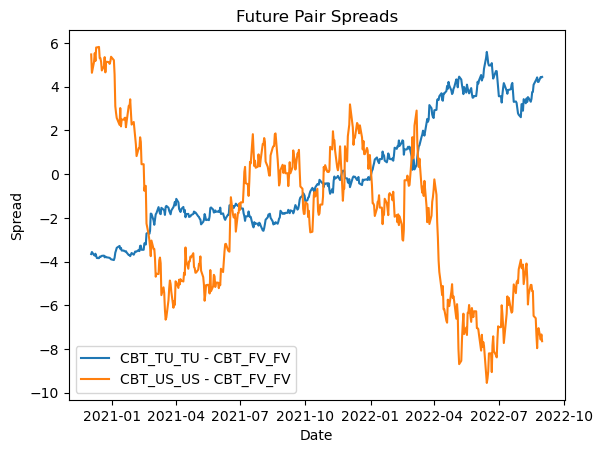

In [15]:
plt.plot(s1, label='CBT_TU_TU - CBT_FV_FV') # plotting spreads on same plot 
plt.plot(s2, label='CBT_US_US - CBT_FV_FV')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('Future Pair Spreads')

In [16]:
corr_spread = s1.corrwith(s2).item() # correlation between s1 and s2 
f'Correlation between the two spreads: {round(corr_spread,2)}'

'Correlation between the two spreads: -0.69'

The prediction of an inverse correlation is confirmed after calculating a correlation coefficient of -0.69. This indicates that there is a moderate inverse relationship between the two spreads. It is worth to note that both spreads involve the future contract CBT_FV_FV, so in reality, both spreads are just the multiplied future price shifted by the same value. To examine this further, the correlation between CBT_TU_TU and CBT_US_US (with some multiplier) is also calculated 

In [17]:
corr_price = tu.corrwith(us).item() # correlation between CBT_TU_TU and CBT_US_US 
f'Correlation between the CBT_TU_TU and CBT_US_US: {round(corr_price,2)}'

'Correlation between the CBT_TU_TU and CBT_US_US: 0.91'

It can be noted that there is an extremely strong positive correlation between the future contract prices of CBT_TU_TU and CBT_US_US. This can also be confirmed visually by looking at the plots shown in **3.1**. It is interesting to note that by subtracting the same varying value from both contracts to form a spread (applying a transformation), the resulting time-series is now inversely correlated. Initially, the correlation between the prices is $r = 0.91$. After applying this *transformation*, the correlation becomes $r = -0.69$. 

***

**3.3 Spread Statistics**

We now should calculate statistics for the spreads. However, we should first examine if the data is stationary, otherwise much of the statistics will be meaningless as the values change in time. We will quantitatively test this withi the Augmented Dickey-Fuller test.

In [58]:
s1_stationarity = adfuller(s1)
print('s1 stationarity p-value: ' + str(round(s1_stationarity[1],3)))

s2_stationarity = adfuller(s2)
print('s2 stationarity p-value: ' + str(round(s2_stationarity[1],3)))

s1 stationarity p-value: 0.901
s2 stationarity p-value: 0.274


A p-value > 0.05 indicates that the time-series is not stationary. In this case, the sample statistics don't mean much as the mean and volatility change in time. We will not calculate sample statistics here and instead, will first normalize these values with moving averages. We will now observe for any autocorrelation in this time-series.

In [201]:
s1_corr = pd.DataFrame(index=np.arange(1,100,1), columns=(['Autocorrelation']))
s2_corr = s1_corr.copy()
for i in range(1, 100):
    s1_corr.loc[i] = s1['Spread'].autocorr(i)
    s2_corr.loc[i] = s2['Spread'].autocorr(i)

Text(0.5, 1.0, '0.7595 CBT_US_US - CBT_FV_FV (s2)')

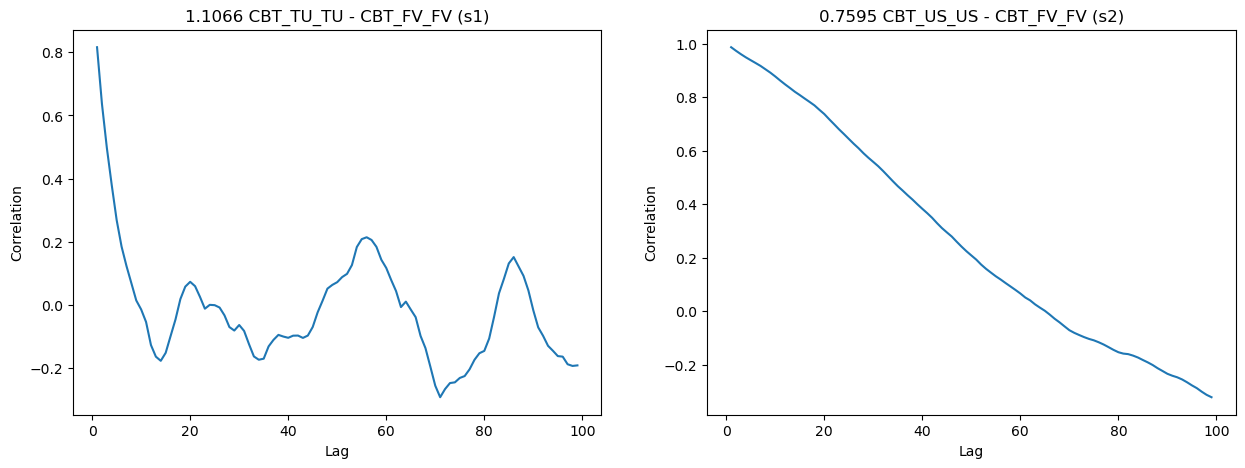

In [202]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5)) # plotting spreads on separate plots 
ax1.plot(s1_corr)
ax2.plot(s2_corr)

ax1.set_xlabel('Lag')
ax1.set_ylabel('Correlation')
ax1.set_title('1.1066 CBT_TU_TU - CBT_FV_FV (s1)')

ax2.set_xlabel('Lag')
ax2.set_ylabel('Correlation')
ax2.set_title('0.7595 CBT_US_US - CBT_FV_FV (s2)')

It can be seen that the autocorrelation initially is extremely high and decreases suddenly as the lag increases. For $s_1$, the autocorrelation oscillates around 0 after some time while the autocorrelation of $s_2$ decreases and ends up having a negative correlation. The high initial correlation can be explained by the fact that the spreads are non-stationary; tomorrow's value is likely to be close to today's value. 

***

**3.4 N day rolling average and volatility**

4 different moving averages and volatilites are calculated for both spreads (10, 20, 50, 100). The moving averages are plotted with their respective spreads. This normalization plot allows for better comparison (by hopefully making the data non-stationary)

In [26]:
N = [10, 20, 50, 100] # chosen N for moving day averages 

s1_mavg = pd.DataFrame(columns=N, index=s1.index)
s1_vol = pd.DataFrame(columns=N, index=s1.index)
s2_mavg = pd.DataFrame(columns=N, index=s2.index)
s2_vol = pd.DataFrame(columns=N, index=s2.index)
for n in N:
    s1_mavg[n] = s1.rolling(n).mean().dropna()
    s2_mavg[n] = s2.rolling(n).mean().dropna()
    s1_vol[n] = s1.rolling(n).std().dropna()
    s2_vol[n] = s2.rolling(n).std().dropna()

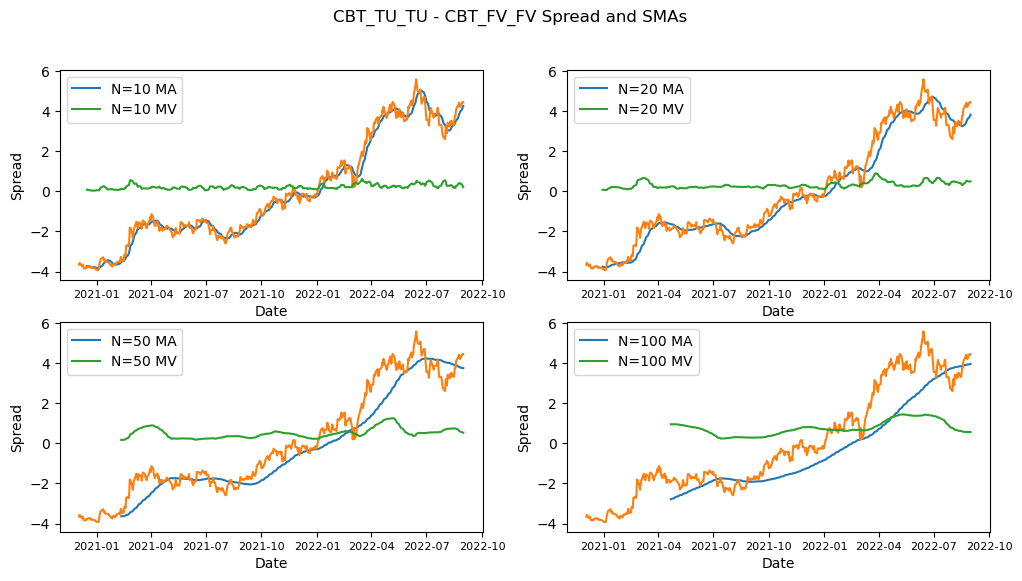

In [27]:
# Plotting spread 1 and N day moving averages 
fig, axs = plt.subplots(2,2, figsize=(12,6)) 
fig.suptitle('CBT_TU_TU - CBT_FV_FV Spread and SMAs')
axs[0,0].plot(s1_mavg[10], label='N=10 MA')
axs[0,0].plot(s1)
axs[0,0].plot(s1_vol[10], label='N=10 MV')

axs[0,1].plot(s1_mavg[20], label='N=20 MA')
axs[0,1].plot(s1)
axs[0,1].plot(s1_vol[20], label='N=20 MV')

axs[1,0].plot(s1_mavg[50], label='N=50 MA')
axs[1,0].plot(s1)
axs[1,0].plot(s1_vol[50], label='N=50 MV')

axs[1,1].plot(s1_mavg[100], label='N=100 MA')
axs[1,1].plot(s1)
axs[1,1].plot(s1_vol[100], label='N=100 MV')

for ax in axs.flat:
    ax.legend()
    ax.set_xlabel('Date')
    ax.set(xlabel='Date', ylabel='Spread')
    ax.tick_params(axis='x', labelsize=8)

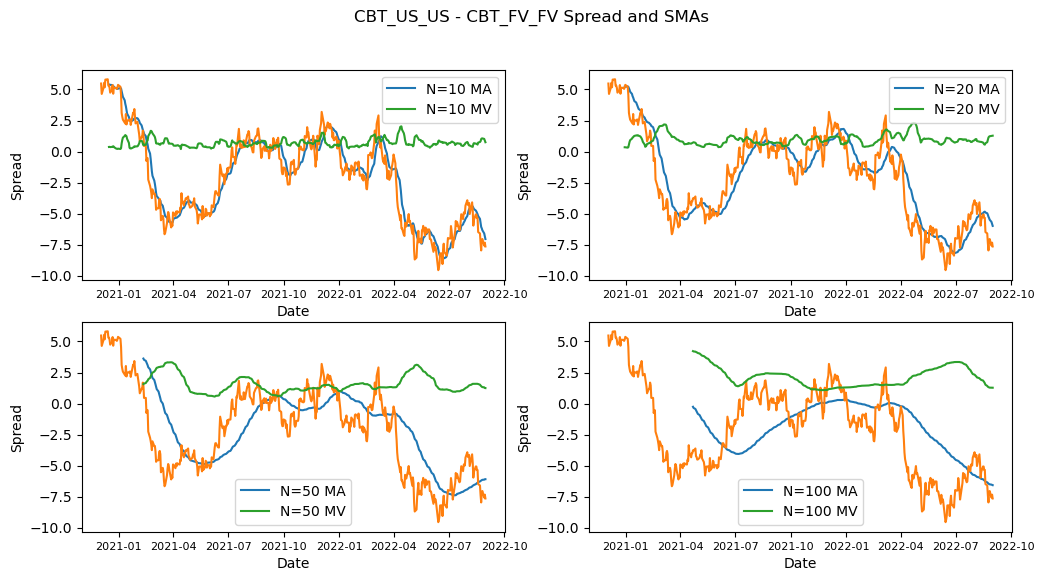

In [29]:
# Plotting spread 2 and N day moving averages 
fig, axs = plt.subplots(2,2, figsize=(12,6))
fig.suptitle('CBT_US_US - CBT_FV_FV Spread and SMAs')
axs[0,0].plot(s2_mavg[10], label='N=10 MA')
axs[0,0].plot(s2)
axs[0,0].plot(s2_vol[10], label='N=10 MV')

axs[0,1].plot(s2_mavg[20], label='N=20 MA')
axs[0,1].plot(s2)
axs[0,1].plot(s2_vol[20], label='N=20 MV')

axs[1,0].plot(s2_mavg[50], label='N=50 MA')
axs[1,0].plot(s2)
axs[1,0].plot(s2_vol[50], label='N=50 MV')

axs[1,1].plot(s2_mavg[100], label='N=100 MA')
axs[1,1].plot(s2)
axs[1,1].plot(s2_vol[100], label='N=100 MV')

for ax in axs.flat:
    ax.legend()
    ax.set(xlabel='Date', ylabel='Spread')
    ax.tick_params(axis='x', labelsize=8)

The N day rolling averages track the general trend of the spreads in both cases. As the window of the moving average gets bigger, it is becomes more lagged and becomes smoother as it takes more outliers (or larger values) to shift the moving average. The moving averages are representative of the general trends we saw earlier (uptrend / downtrend). It is interesting to note that the moving volatility curve is relatively flat. However, the moving volatility deviates more as N increases.

***

**3.5 Difference between spread and N day moving average**

Earlier, we tested stationarity of the spreads and found that the time-series wasn't stationary. As a result, we couldn't calculate statistics and make comparisons (or meaningful ones). Now, we will subtract the moving average from the spread in an effort to normalize these values and make the data stationary. The moving average alllows us to dedrift the data. $d_1$ corresponds with $s_1$ while $d_2$ corresponds with $s_2$

In [30]:
d1 = s1.values - s1_mavg # difference between s1 and moving averages (denoted d1)
d2 = s2.values - s2_mavg # difference between s2 and moving averages (denoted d2)

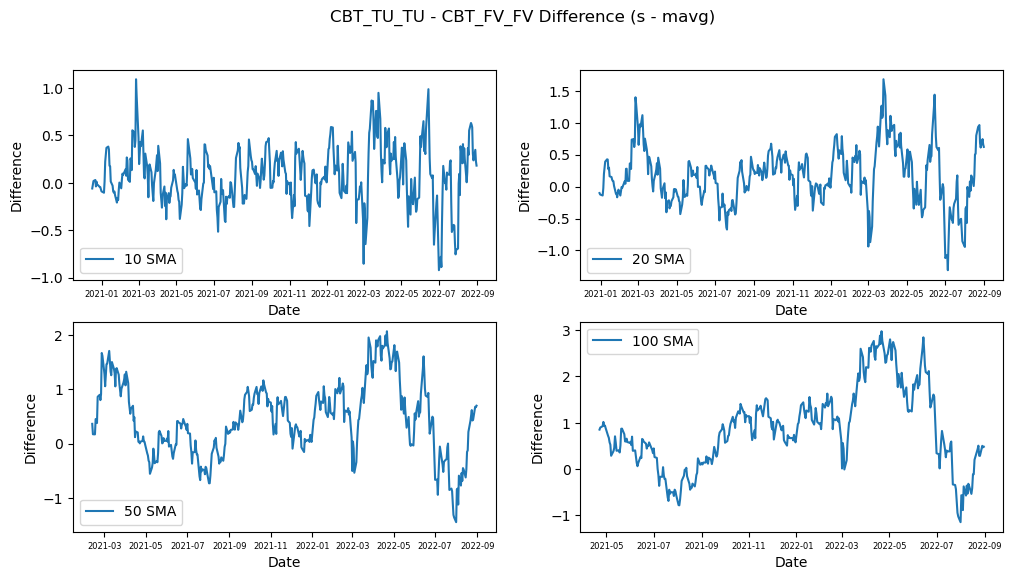

In [31]:
fig, axs = plt.subplots(2,2, figsize=(12,6)) # plotting d1 
fig.suptitle('CBT_TU_TU - CBT_FV_FV Difference (s - mavg)')
axs[0,0].plot(d1[10], label='10 SMA')
axs[0,1].plot(d1[20], label='20 SMA')
axs[1,0].plot(d1[50], label='50 SMA')
axs[1,1].plot(d1[100], label='100 SMA')

for ax in axs.flat:
    ax.legend()
    ax.set(xlabel='Date', ylabel='Difference')
    ax.tick_params(axis='x', labelsize=6)

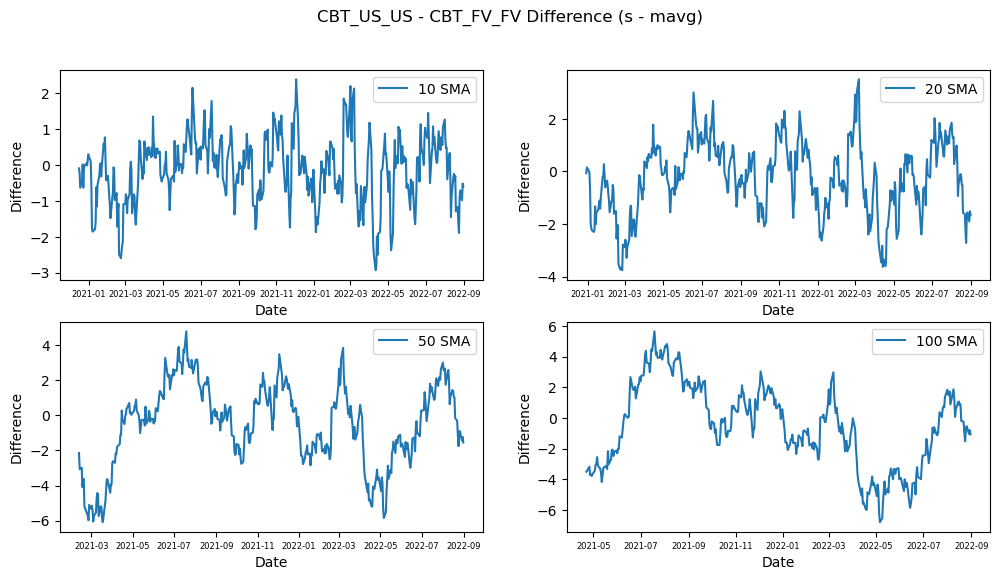

In [20]:
fig, axs = plt.subplots(2,2, figsize=(12,6)) # plotting d2
fig.suptitle('CBT_US_US - CBT_FV_FV Difference (s - mavg)')
axs[0,0].plot(d2[10], label='10 SMA')
axs[0,1].plot(d2[20], label='20 SMA')
axs[1,0].plot(d2[50], label='50 SMA')
axs[1,1].plot(d2[100], label='100 SMA')

for ax in axs.flat:
    ax.legend()
    ax.set(xlabel='Date', ylabel='Difference')
    ax.tick_params(axis='x', labelsize=6)

When looking at the differences, the values appear to be normalized in the sense that the y-axis values are roughly the same. The difference with lower moving day averages are noisier than the differences with higher values of N. The applies with both spreads. The differences do appear to oscillate around a mean-value and also look to be stationary. Nonetheless, we should test for stationarity before calculating sample statistics.  

***

**3.6 Difference Statistics**

First, we examine if the data is stationary to determine whether it is reasonable to calculate sample statistics and make direct comparisons. If the data is stationary, we will then be able to calculate sample and tail statistics. 

*3.6.1 CBT_TU_TU - CBT_FV_FV*

In [116]:
d1_stationarity = d1.apply(lambda x : adfuller(x.dropna())[1]).to_frame('d1 Stationarity p-value')
d1_stationarity

,d1 Stationarity p-value
10,1.030393e-09
20,1.389035e-04
50,3.544407e-02
100,2.346672e-01


The p-values for all differences of varying N is less than 0.05, indicating that the time-series of differences for each value of N is stationary. We can now go ahead and calculate statistics like mean and variance as we know these do not change in time. We will also examine the autocorrelation of both these differences. However, for simplicity of charts, we will show the result for only N = 10 as this has the lowest p-value when testing for stationarity. Lags of up to 100 are also used.

<AxesSubplot: title={'center': 'N = 10 d1 Autocorrelation'}, xlabel='Lag', ylabel='Correlation'>

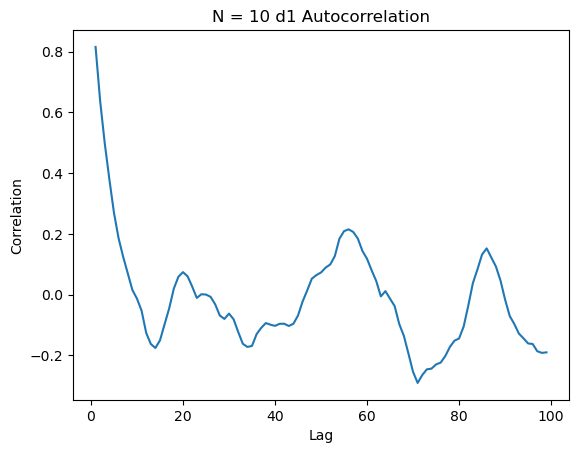

In [212]:
d1_corr = pd.DataFrame(index=np.arange(1,100,1), columns=(['Autocorrelation']))
for i in range(1, 100):
    d1_corr.loc[i] = d1[10].autocorr(i)

d1_corr.plot(title='N = 10 d1 Autocorrelation', xlabel='Lag', ylabel='Correlation', legend=False)

A similar trend is seen from above. There is a high correlation initially, but this decreases dramatically and begins to oscillate around 0. Further statistical inference can be later used to determine the significance of these correlations. We will calculate the univariate statistics now due to the non-stationary nature.

In [21]:
d1.describe() # univariate statistics of d1 

,10,20,50,100
count,445.000000,435.000000,405.000000,355.000000
mean,0.082147,0.172247,0.443516,0.865466
std,0.300263,0.438505,0.670903,0.871196
min,-0.922635,-1.308490,-1.445824,-1.144650
25%,-0.104976,-0.106448,-0.011468,0.287257
50%,0.073280,0.160784,0.424045,0.837259
75%,0.261858,0.449557,0.896030,1.362890
max,1.093464,1.680733,2.064559,2.975411


First, we see that the mean and volatility increases as the value of N increases. It is interesting to note that the 25-percentile has a value of -0.01, which is quite different from both the 20 and 100 day differences. We will now examine tail statistics via skewness and kurtosis.

In [22]:
d1_tail = pd.DataFrame(index=d1.columns,columns=['Skewness', 'Kurtosis']) # tail statistics of d1 
d1_tail['Skewness'] = d1.skew()
d1_tail['Kurtosis'] = d1.kurtosis()

d1_tail

,Skewness,Kurtosis
10,-0.044185,1.004947
20,0.101417,0.659215
50,0.062602,-0.279602
100,0.283274,-0.302554


When examining skewness and kurtosis, it can be seen that skewness increases as N increases while kurtosis decreases. We will also plot a histogram of these differences and examine their distributions. 

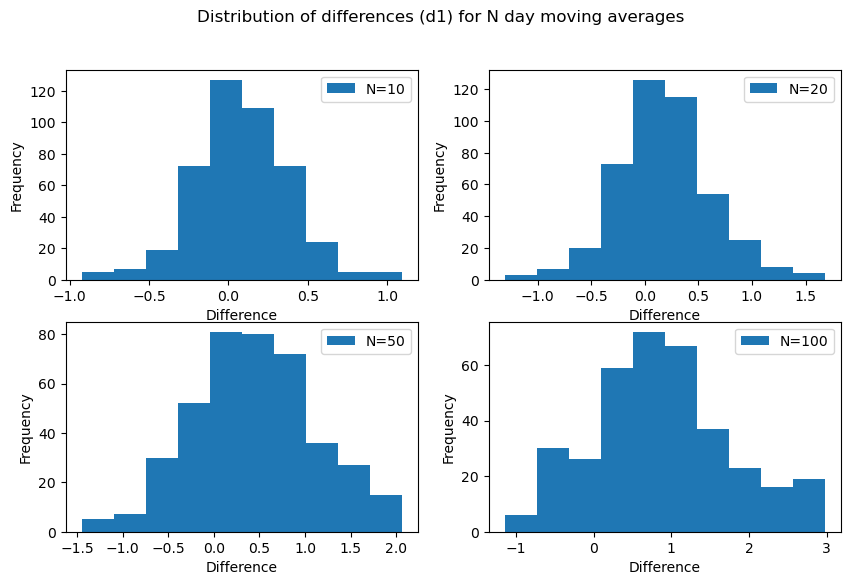

In [118]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

fig.suptitle('Distribution of differences (d1) for N day moving averages')
axs[0,0].hist(d1[10],label='N=10')
axs[0,1].hist(d1[20],label='N=20')
axs[1,0].hist(d1[50],label='N=50')
axs[1,1].hist(d1[100],label='N=100')

for ax in axs.flat:
    ax.legend()
    ax.set(xlabel='Difference', ylabel='Frequency')

These differences appear to follow a normal-like distribution, but we will test this quantitatively with the Shapiro-Wilks test.

In [115]:
d1_shapiro = d1.apply(lambda x : stats.shapiro(x.dropna())[1]).to_frame('d1 Normality p-value')
d1_shapiro

,d1 Normality p-value
10,0.000803
20,0.070338
50,0.225951
100,0.000412


It turns out that the distribution for all the distributions are not normal. Only the distributions for N = 20 and N = 50 are, while N = 10 and N = 100 have non-normal distributions. This assumes a p-value of 0.05. We will now perform the same analysis on the second spread. 

***

*3.6.1 CBT_US_US - CBT_FV_FV*

In [117]:
d2_stationarity = d2.apply(lambda x : adfuller(x.dropna())[1]).to_frame('d2 Stationarity p-value')
d2_stationarity

,d2 Stationarity p-value
10,2.917936e-09
20,4.152569e-04
50,1.009432e-01
100,1.989018e-01


Similarly to $d_1$, we see that the p-value is < 0.05 for all N values. This indicates that the differences are stationary. We were successful in removing the drift from the data by using moving averages. We will once again calculate the autocorrelation, but this time with $d_2$. Lags up to 100 are used.

<AxesSubplot: title={'center': 'N = 10 d2 Autocorrelation'}, xlabel='Lag', ylabel='Correlation'>

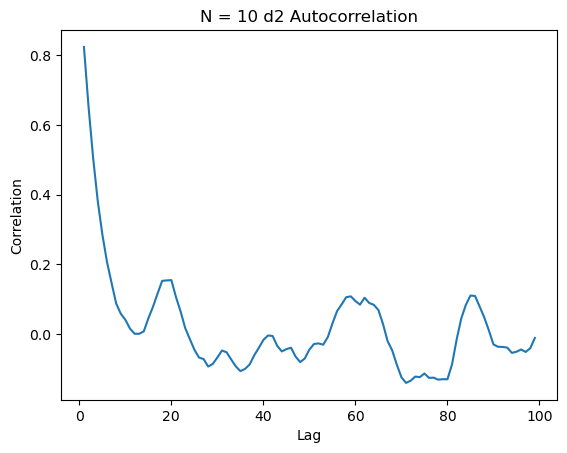

In [211]:
d2_corr = pd.DataFrame(index=np.arange(1,100,1), columns=(['Autocorrelation']))
for i in range(1, 100):
    d2_corr.loc[i] = d2[10].autocorr(i)

d2_corr.plot(title='N = 10 d2 Autocorrelation', xlabel='Lag', ylabel='Correlation', legend=False)

The same trend of $d_1$ can be observed here. There is high autocorrelation initially before dramatically decreasing and then oscillating around 0. Like above, statistical inference should later be used to see if the autocorrelation is significant. We now look at the univariate statistics for $d_2$.

In [23]:
d2.describe() # univariate statistics of d2

,10,20,50,100
count,445.000000,435.000000,405.000000,355.000000
mean,-0.130337,-0.258670,-0.532385,-0.544203
std,0.914681,1.367058,2.326910,2.670277
min,-2.932141,-3.757985,-6.084808,-6.797128
25%,-0.678061,-1.160173,-2.053370,-2.431266
50%,-0.082844,-0.192505,-0.257012,-0.635521
75%,0.476989,0.756667,1.067016,1.560046
max,2.393763,3.509398,4.771728,5.653477


Much of the stats here show similar trends to $d_1$. The mean strays further away from 0 as N increases, though this time it is in the opposite direction (negatively). Volatility also increases with N (like $d_1$). We'll also look at the tail-statistics.

In [24]:
d2_tail = pd.DataFrame(index=d2.columns,columns=['Skewness', 'Kurtosis']) # tail statistics of d2 
d2_tail['Skewness'] = d2.skew()
d2_tail['Kurtosis'] = d2.kurtosis()

d2_tail

,Skewness,Kurtosis
10,-0.285761,0.175781
20,-0.244816,-0.281192
50,-0.387307,-0.415883
100,-0.047255,-0.720009


The kurtosis is similar to $d_1$ in that it decreases, though it starts at a smaller value but also ends at a more negative value. The skewness is the opposite of $d_1$, in that it gets closer to 0 as N increases. We will also examine a histogram of these differences like with $d_1$.

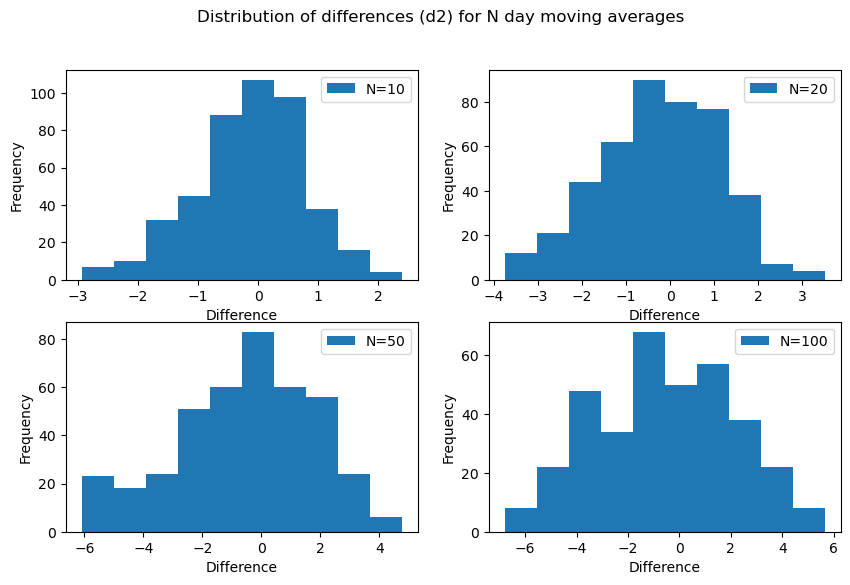

In [119]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

fig.suptitle('Distribution of differences (d2) for N day moving averages')
axs[0,0].hist(d2[10],label='N=10')
axs[0,1].hist(d2[20],label='N=20')
axs[1,0].hist(d2[50],label='N=50')
axs[1,1].hist(d2[100],label='N=100')

for ax in axs.flat:
    ax.legend()
    ax.set(xlabel='Difference', ylabel='Frequency')

These histograms do not appear to be normal. The tails are much fatter and the distributions don't appear to be symmetrical. We will confirm this once again quantitatively.

In [121]:
d2_shapiro = d2.apply(lambda x : stats.shapiro(x.dropna())[1]).to_frame('d2 Normality p-value')
d2_shapiro

,d2 Normality p-value
10,0.021298
20,0.009019
50,0.000009
100,0.003100


Our hypothesis was correct in that none of the distributions are normal. The p-values are all < 0.05.

***

**3.7 Correlation of Differences**

It is also reasonable to calculate the correlation of the differences now that they're normalized. In this case, the correlations are calculated between the respective N day moving average differences (i.e the correlation between $d_1$ and $d_2$ when N = 20).

In [25]:
corr = pd.DataFrame(index=N,columns=['Correlation']) # correlation between differences of the same N day moving average 
for n in N:
    corr.loc[n] = d1[[n]].corrwith(d2[[n]]).item()

corr

,Correlation
10,-0.676356
20,-0.729671
50,-0.760099
100,-0.769566


Here, a similar correlation is seen when comparing this coefficient to the coefficient calculated with the two spreads. However, it is interesting to note that as N increases, the correlation also increases in magnitude. The correlation when N = 10 is similar to the correlation between the spreads themselves (a value of $r = -0.69$).

***

## 4 Conclusion

In this assignment, future prices were obtained from the OWF database and spreads were calculated. The selected future contracts were based on the last two digits of my student ID which resulted in CBT_FV_FV, CBT_US_US, and CBT_TU_TU being used. The spreads were then validated with spreads given in the instructions of the homework to ensure that the data was collected and processed properly. Afterwards, statistical analysis was conducted on the spreads. The CBT_TU_TU - CBT_FV_FV had an positive trend while CBT_US_US - FBT_FV_FV had a negative trend. They appeared to be inversely correlated and the calculations confirmed that observation with $r = -0.69$. The spreads showed to be stationary so no univariate statistics were calculated as they would be meaningless. Instead, autocorrelation was calculated for lags up to 100. They initially show a correlation of 1.0 but then drastically decrease towards 0. However, the second spread ended up having a negative autocorrelation at higher lags. 

The spreads were then normalized in the sense that N day moving averages (10, 20, 50, 100) were calculated to obtain the difference ($s_i - mavg_i[N]$). When plotting, the moving averages tracked more closely with lower values of N while lagged behind as N increased. The moving volatilities also appeared to be relatively flat. These differences were first tested to see if they were stationary before calculating any statistics to ensure that the mean and variance aren't changing in time. The Augmented Dickey-Fuller test showed that the differences were stationary for each value of N, thus sample statistics were calculated. Similarly, we saw autocorrelations that quickly decayed to 0 as lag increased. This pattern was seen in both differences. The differences showed means relatively close to zero, but trended away as N increased while volatility also increased with N. Tail statistics (skewness and kurtosis) were also calculated. $d_1$ and $d_2$ showed similar decreasing trends in kurtosis with increasing values of N while there was an inverse relationship between the two differences with skewness. 

The distributions of the differences was also plotted and many of the difference distributions showed non-normal distributions. However, the distributions of N = 20 and N = 50 for $d_1$ were normal. Finally, correlation was calculated between the time series of the differences of a particular N (i.e N = 5, $d_1$ and $d_2$). This yielded a similar correlation to that of $s_1$ and $s_2$ when the value of N was low. As N increaesd, the correlation between the differences became more negative. 